In [1]:
!pip install simpy

import scipy.stats as stats
import random
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameter Setting

In [7]:
def inv_gen_exp_v(p, *params):
    k = params[0]
    sigma = params[1]
    mu = params[2]

    if k != 0:
        value = mu + (sigma / k) * ((-np.log(p))**(-k) - 1)
        if value < 0:
            value = 0
        return value
    else:
        value = mu - sigma * np.log(-np.log(p))
        if value < 0:
            value = 0
        return value

def inv_lognorm(p, *params):
    return stats.lognorm(*params).ppf(p)

def inv_pareto(p, *params):
    return stats.pareto(*params).ppf(p)

def inv_gumbel_max(p, *params):
    mu = params[0]
    beta = params[1]
    value = mu - beta * np.log(-np.log(p))
    return max(value, 0)


def inv_normal(p, *params):
    mu = params[0]
    sigma = params[1]
    value = stats.norm(loc=mu, scale=sigma).ppf(p)
    return max(value, 0)

In [8]:
# 정책(policy) 설정
# 각 policy는 특정 교차로에서 신호 조합을 정의함
L = 1  # 좌회전
S = 2  # 직진
R = 3  # 우회전

policy = [
    [(1, S), (1, R), (3, S), (3, R)],  # 첫 번째 신호 조합
    [(1, R), (2, R), (3, S), (3, R), (4, R)],  # 두 번째 신호 조합
    [(2, S), (2, R), (4, S), (4, R)],  # 세 번째 신호 조합
    [(2, R), (2, S), (2, L), (3, R), (4, R)],  # 네 번째 신호 조합
    [(1, R), (2, L), (2, R), (3, R), (4, L), (4, R)]  # 다섯 번째 신호 조합
]

policy1 = [
    [(1, S), (1, R), (3, S), (3, R)],
    [(2, S), (2, R), (4, S), (4, R)],
    [(1, R), (2, L), (2, R), (3, R), (4, L), (4, R)]
]

policy2 = [
    [(1, S), (1, R), (3, S), (3, R)],
    [(1, R), (2, R), (4, L), (4, S), (4, R)],
    [(2, R), (2, S), (2, L), (3, R), (4, R)],
]

policy3 = [
    [(1, S), (1, R), (3, S), (3, R)],
    [(1, R), (2, R), (4, L), (4, S), (4, R)],
    [(2, S), (2, R), (4, S), (4, R)],
    [(2, R), (2, S), (2, L), (3, R), (4, R)],
]

policy_list = [policy, policy1, policy2, policy3]  # 모든 정책 리스트

# 신호 지속 시간 설정
duration = [50, 15, 50, 25, 30]  # 정책별 신호 지속 시간
duration1 = [65, 60, 45]
duration2 = [65, 40, 65]
duration3 = [65, 20, 50, 35]

durations = [duration, duration1, duration2, duration3]

# 신호 지속 시간 조합 생성
duration_list = [[] for _ in range(4)]  # 빈 리스트 초기화
for index, dur in enumerate(durations):
    for i in range(len(dur)):
        for j in range(len(dur)):
            if j != i:  # 동일한 인덱스가 아닐 때만
                tmp = dur.copy()
                tmp[i] += 5  # 선택된 신호 시간 증가
                tmp[j] -= 5  # 다른 신호 시간 감소
                duration_list[index].append(tmp)

# 초기 조건 설정
init_cond = {
    (1, L): None, (1, S): 30, (1, R): 15,  # 1번 교차로
    (2, L): 30, (2, S): 30, (2, R): 15,  # 2번 교차로
    (3, L): None, (3, S): 30, (3, R): 15,  # 3번 교차로
    (4, L): 30, (4, S): 30, (4, R): 15   # 4번 교차로
}

# 도착 시간 통계 설정
arr_stats = {
    (1, L): None,
    (1, S): [inv_gen_exp_v, 0.6029, 2.0382, 2.1603],
    (1, R): [inv_gen_exp_v, 0.4242, 10.408, 8.9766],
    (2, L): [inv_gen_exp_v, 0.549, 1.7656, 1.8556],
    (2, S): [inv_gen_exp_v, 0.4944, 1.1941, 1.3215],
    (2, R): [inv_gen_exp_v, 0.4888, 16.913, 24.951],
    (3, L): None,
    (3, S): [inv_gen_exp_v, 0.5880, 4.2666, 4.5339],
    (3, R): [inv_gen_exp_v, 0.5121, 20.909, 20.477],
    (4, L): [inv_gen_exp_v, 0.3937, 12.021, 10.384],
    (4, S): [inv_gen_exp_v, 0.6012, 2.2478, 2.278],
    (4, R): [inv_gen_exp_v, 0.4513, 11.883, 11.724]
}

# 출발 시간 통계 설정
dep_stats = {
    (1, L): None,
    (1, S): [inv_gen_exp_v, 0.1613, 1.1923, 1.4272],
    (1, R): [inv_gen_exp_v, -0.1320, 10.326, 12.608],
    (2, L): [inv_gen_exp_v, -0.0021, 0.9442, 1.2554],
    (2, S): [inv_gen_exp_v, 0.0851, 1.026, 1.299],
    (2, R): [inv_lognorm, 1.3268, 1.9494, 0.58587],
    (3, L): None,
    (3, S): [inv_gen_exp_v, 0.2758, 1.9706, 3.155],
    (3, R): [inv_gumbel_max, 11.165, 8.5962],
    (4, L): [inv_gumbel_max, 1.9936, 1.4816],
    (4, S): [inv_lognorm, 0.7194, 0.3835],
    (4, R): [inv_lognorm, 2.077, 1.683, 2.5538]
}

# 도착 시간 역함수 호출 함수 정의
def get_arr_time(p, i, j):
    dist = arr_stats[(i + 1, j + 1)]  # 교차로와 신호 유형에 따른 분포 정보
    return dist[0](p, *dist[1:])  # 역함수 호출

# 출발 시간 역함수 호출 함수 정의
def get_dep_time(p, i, j):
    dist = dep_stats[(i + 1, j + 1)]  # 교차로와 신호 유형에 따른 분포 정보
    return dist[0](p, *dist[1:])  # 역함수 호출

# 차로 용량 설정
capacity_list = [[0, 30, 15], [30, 30, 15], [0, 30, 15], [30, 30, 15]]

# 출발 차로 용량 설정
dep_capacity_list = [45, 75, 45, 75]
dep_queue = [45, 75, 45, 75]

# 신호 지속 시간 설정 (초 단위)
dep_duration = [
    [120, 30],  # 초록, 빨강 신호 지속 시간 (초 단위)
    [90, 30],
    [120, 30],
    [90, 90]
]

# 차량 소멸 속도 설정 (2초당 1대)
dep_vanishing = [int(dep_duration[i][0] / 2) for i in range(4)]

# 도착 신호 지속 시간 설정
arr_duration = [
    [120, 30],
    [90, 30],
    [120, 30],
    [90, 90]
]

In [9]:
dep_vanishing

[60, 45, 60, 45]

# Define Model & Test One Replicate

In [10]:
class LightControl():

    def __init__(self, env, policy, duration, dep_duration):
        self.env = env

        # 초기화 (각 교차로 및 방향별로 구분)
        self.green_list = [[[] for j in range(3)] for i in range(4)]
        self.red_list = [[[] for j in range(3)] for i in range(4)]

        self.policy = policy  # 신호 제어 정책
        self.duration = duration  # 각 신호 단계의 지속 시간
        self.dep_duration = dep_duration  # 출발 차로 신호 지속 시간

        # 신호등 제어 및 차량 소멸 관리를 위한 프로세스 시작
        self.env.process(self.run_lights())
        self.env.process(self.run_dep_lights())

    def _broadcast(self, subscribers):
        # 구독자에게 신호 변경 알림
        for callback in subscribers:
            callback()

    def run_lights(self):
        # 교차로 신호 제어 프로세스
        while True:
            for i in range(len(self.policy)):

                # 현재 단계의 신호 정책에 따라 초록 신호 전환
                for l, d in self.policy[i]:
                    self._broadcast(self.green_list[l - 1][d - 1])

                # 신호 지속 시간만큼 대기
                yield self.env.timeout(self.duration[i])

                # 초록 신호를 빨강 신호로 전환
                for l, d in self.policy[i]:
                    self._broadcast(self.red_list[l - 1][d - 1])

    def run_dep_lights(self):
        # 출발 차로 차량 소멸 관리 프로세스
        while True:
            for i in range(len(self.dep_duration)):

                # 빨강 신호 동안 차량 소멸 계산
                yield self.env.timeout(self.dep_duration[i][1])
                if dep_queue[i] < dep_vanishing[i]:
                    dep_queue[i] = 0  # 차량 큐가 소멸 속도보다 작으면 0으로 설정
                else:
                    dep_queue[i] -= dep_vanishing[i]  # 차량 큐에서 소멸 차량 수만큼 감소

                # 초록 신호 지속 시간만큼 대기
                yield self.env.timeout(self.dep_duration[i][0])

class Lane():

    def __init__(self, name, env, i, j, capacity):

        self.name = name  # 차로 이름
        self.env = env  # 시뮬레이션 환경
        self.i = i  # 교차로 인덱스
        self.j = j  # 방향 인덱스
        self.capacity = capacity  # 차로 용량
        self.lane_q = []  # 차량 큐
        self.time_q = []  # 차량 도착 시간 큐
        self.green = False  # 신호 상태 (초록 여부)

        self.total_customer = 0  # 총 차량 수
        self.total_delay = 0  # 총 지연 시간
        self.delay_list = []  # 지연 시간 리스트
        self.dep_lane = (i + j) % 4  # 출발 차로 계산

    def add_car(self, car):
        # 차로에 차량 추가
        if self.green and len(self.lane_q) == 0:
            # 차량이 바로 통과할 수 있는 경우
            self.total_customer += 1
            self.delay_list.append(0)

        else:
            if len(self.lane_q) < self.capacity:
                # 차량을 큐에 추가
                self.lane_q.append(car)
                self.time_q.append(self.env.now)

    def move_cars(self):
        # 차량 이동 프로세스
        while self.green and (len(self.lane_q) > 0):

            if dep_queue[self.dep_lane] > dep_capacity_list[self.dep_lane]:  # 출발 차로 용량 초과
                yield self.env.timeout(1)  # 출발 차로가 비워질 때까지 대기

            else:
                car = self.lane_q.pop(0)  # 차량 큐에서 차량 제거
                dep_queue[self.dep_lane] += 1  # 출발 큐에 차량 추가

                delay = self.env.now - self.time_q[0]  # 지연 시간 계산
                if self.total_customer < init_cond[self.i + 1, self.j + 1]:  # 초기 차량 무시
                    delay = 0
                self.time_q.pop(0)

                self.total_customer += 1
                self.total_delay += delay
                self.delay_list.append(delay)

                p = random.random()
                dep_delay = get_dep_time(p, self.i, self.j)  # 출발 지연 시간 계산

                #print(f'car departed at {self.env.now} from {self.name}. delay: {delay:.2f}')
                yield self.env.timeout(dep_delay)

    def green_light(self):
        # 초록 신호 활성화
        self.green = True
        self.env.process(self.move_cars())

    def red_light(self):
        # 빨강 신호 활성화
        self.green = False


def gen_cars(env, lane, i, j):
    # 차량 생성 프로세스

    # 이전 도로의 신호 지속 시간
    green = arr_duration[i][0]  # 초록 신호 시간
    red = arr_duration[i][1]  # 빨강 신호 시간
    cycle = green + red  # 신호 주기

    while True:

        if (env.now + 60) % cycle > green:  # 빨강 신호

            # 도로에 첫 차량이 진입하는 경우 추가 지연
            extra_delay = 0
            if len(lane.lane_q) < 15:
                extra_delay = (15 - len(lane.lane_q)) * 2.5

            jump = cycle - env.now % cycle + extra_delay
            # print(f'line: {lane.name} jump: {jump:.2f} to: {jump + env.now:.2f}')
            yield env.timeout(jump)

        else:  # 초록 신호

            p = random.random()
            delay = get_arr_time(p, i, j)  # 도착 지연 시간 계산

            yield env.timeout(delay)
            lane.add_car(object())


In [11]:
# 시뮬레이션 초기화
env = simpy.Environment()  # SimPy 환경 생성
lights = LightControl(env, policy, duration, dep_duration)  # 신호등 제어 객체 생성
random.seed(123)  # 랜덤 시드 설정

# 구독자 정의
Ltype = ['East', 'South', 'West', 'North']  # 방향 정의
Ldir = ['left', 'straight', 'right']  # 신호 방향 정의
# 각 차로 객체 생성 및 lane_list에 저장
lane_list = [[Lane((str(Ltype[i]) + ' ' + str(Ldir[j])), env, i, j, capacity_list[i][j]) for j in range(3)] for i in range(4)]

# 초록 신호 및 빨강 신호 구독자 정의
for i in range(4):  # 각 교차로에 대해 반복
    for j in range(3):  # 각 방향에 대해 반복
        lights.green_list[i][j].append(lane_list[i][j].green_light)  # 초록 신호 구독자 추가
        lights.red_list[i][j].append(lane_list[i][j].red_light)  # 빨강 신호 구독자 추가

# 초기 조건 설정
for i in range(4):  # 각 교차로에 대해 반복
    for j in range(3):  # 각 방향에 대해 반복
        if init_cond[(i + 1, j + 1)] == None:  # 초기 조건이 없는 경우 건너뜀
            continue
        # 초기 차량 수만큼 큐에 추가
        for k in range(int(init_cond[(i + 1, j + 1)])):
            lane_list[i][j].add_car(object())  # 차량 객체 추가

# 차량 생성 프로세스 시작
for i in range(4):  # 각 교차로에 대해 반복
    for j in range(3):  # 각 방향에 대해 반복
        if (i, j) == (0, 0) or (i, j) == (2, 0):  # 특정 방향 제외
            continue
        env.process(gen_cars(env, lane_list[i][j], i, j))  # 차량 생성 프로세스 시작

# 시뮬레이션 실행 (2400초 동안)
env.run(2400)  # 시뮬레이션 실행


In [12]:
# 변수 초기화: 전체 지연 시간과 전체 고객 수를 0으로 초기화
total_delay = 0  # 전체 지연 시간을 저장할 변수
total_customer = 0  # 전체 고객 수를 저장할 변수

# 이중 for문으로 lane_list의 각 차선을 순회
for i in range(4):  # i는 행을 나타냄 (0부터 3까지)
    for j in range(3):  # j는 열을 나타냄 (0부터 2까지)
        # 특정 좌표 (0,0) 또는 (2,0)인 경우는 건너뜀
        if (i, j) == (0, 0) or (i, j) == (2, 0):
            continue

        # 현재 차선의 전체 고객 수와 전체 지연 시간을 누적 합산
        total_customer += lane_list[i][j].total_customer  # 현재 차선의 총 고객 수를 전체에 추가
        total_delay += lane_list[i][j].total_delay  # 현재 차선의 총 지연 시간을 전체에 추가

        # 새로 유입된 고객 수 계산 (현재 차선의 총 고객 수 - 초기 조건 값)
        lane_new_customer = lane_list[i][j].total_customer - init_cond[(i + 1, j + 1)]

        # 현재 차선의 요약 정보 출력
        print(f'{lane_list[i][j].name} summary--------------------')  # 차선 이름 출력
        print(f'total customer: {lane_list[i][j].total_customer}')  # 총 고객 수 출력
        print(f'new customer: {lane_new_customer}')  # 새로 유입된 고객 수 출력
        print(f'average delay: {lane_list[i][j].total_delay / lane_new_customer:.2f}')  # 평균 지연 시간 출력
        print()

# 전체 결과 요약 출력
print('/' * 20)  # 구분선 출력
print(f'total customer: {total_customer}')  # 전체 고객 수 출력
print(f'total delay: {total_delay:.2f}')  # 전체 지연 시간 출력
print(f'average delay: {total_delay / total_customer:.2f}')  # 전체 평균 지연 시간 출력


East straight summary--------------------
total customer: 50
new customer: 20
average delay: 1480.88

East right summary--------------------
total customer: 75
new customer: 60
average delay: 243.83

South left summary--------------------
total customer: 108
new customer: 78
average delay: 349.67

South straight summary--------------------
total customer: 75
new customer: 45
average delay: 328.60

South right summary--------------------
total customer: 27
new customer: 12
average delay: 15.06

West straight summary--------------------
total customer: 78
new customer: 48
average delay: 610.17

West right summary--------------------
total customer: 54
new customer: 39
average delay: 137.87

North left summary--------------------
total customer: 46
new customer: 16
average delay: 739.20

North straight summary--------------------
total customer: 49
new customer: 19
average delay: 299.35

North right summary--------------------
total customer: 26
new customer: 11
average delay: 338.38

///

# N Replications

In [13]:
def run_indi_simulations(policy, duration, seed_number):

  # 시뮬레이션 초기화
  env = simpy.Environment()  # SimPy 환경 생성
  lights = LightControl(env, policy, duration, dep_duration)  # 신호등 제어 객체 생성
  random.seed(seed_number)  # 랜덤 시드 설정

  # 차선 리스트 정의
  Ltype = ['East', 'South', 'West', 'North']  # 차선 방향
  Ldir = ['left', 'straight', 'right']  # 차선 이동 방향
  lane_list = [[Lane((str(Ltype[i])+' '+str(Ldir[j])), env, i, j, capacity_list[i][j]) for j in range(3)] for i in range(4)]

  # 신호등의 빨간불과 초록불 설정
  for i in range(4):
      for j in range(3):
          lights.green_list[i][j].append(lane_list[i][j].green_light)  # 초록불 리스트 추가
          lights.red_list[i][j].append(lane_list[i][j].red_light)  # 빨간불 리스트 추가

  # 초기 조건 설정
  for i in range(4):
    for j in range(3):
      if init_cond[(i+1,j+1)]==None:  # 초기 조건이 없으면 건너뜀
        continue
      for k in range(int(init_cond[(i+1,j+1)])):
        lane_list[i][j].add_car(object())  # 초기 차량 추가

  # 차량 생성 프로세스 시작
  for i in range(4):
      for j in range(3):
          if (i,j)==(0,0) or (i,j)==(2,0):  # 특정 좌표 건너뜀
              continue
          env.process(gen_cars(env, lane_list[i][j], i,j))  # 차량 생성 프로세스 추가

  env.run(2400)  # 시뮬레이션 실행 (2400초)

  # 성능 측정 계산
  total_delay=0; total_customer=0  # 총 지연 시간과 총 고객 수 초기화

  for i in range(4):
      for j in range(3):
          if (i,j)==(0,0) or (i,j)==(2,0):  # 특정 좌표 건너뜀
              continue
          total_customer+=lane_list[i][j].total_customer  # 전체 고객 수 누적
          total_delay+=lane_list[i][j].total_delay  # 전체 지연 시간 누적
          lane_new_customer = lane_list[i][j].total_customer - init_cond[(i+1,j+1)]  # 새 고객 수 계산

  return total_delay/total_customer  # 평균 지연 시간 반환

# 결과 리스트 초기화
result_list = [[] for _ in range(4)]
n_rep = 20  # 반복 횟수

# 정책별 시뮬레이션 실행
for i in range(len(policy_list)):
    print(f'<{i}th policy>')  # 현재 정책 출력
    for j in range(len(duration_list[i])):
        print(f'{j}th duration')  # 현재 지속 시간 출력

        data=[]
        for k in range(n_rep):
          data.append(run_indi_simulations(policy_list[i], duration_list[i][j], 1000*i+100*j+k))  # 개별 시뮬레이션 실행 후 데이터 수집
        result_list[i].append([np.mean(data), np.std(data)])  # 평균 및 표준편차 저장

        print()


<0th policy>
0th duration

1th duration

2th duration

3th duration

4th duration

5th duration

6th duration

7th duration

8th duration

9th duration

10th duration

11th duration

12th duration

13th duration

14th duration

15th duration

16th duration

17th duration

18th duration

19th duration

<1th policy>
0th duration

1th duration

2th duration

3th duration

4th duration

5th duration

<2th policy>
0th duration

1th duration

2th duration

3th duration

4th duration

5th duration

<3th policy>
0th duration

1th duration

2th duration

3th duration

4th duration

5th duration

6th duration

7th duration

8th duration

9th duration

10th duration

11th duration



In [14]:
result_list

[[[205.20128632066616, 24.25926083372351],
  [169.3458281894266, 26.070275275929085],
  [209.44012258179814, 26.500354711363162],
  [199.3141467297032, 22.23438056209146],
  [180.4901541825522, 36.65721255679702],
  [202.34893789378708, 23.3752718964692],
  [203.95221616995863, 31.30437278090093],
  [189.9791551050497, 31.548162100379773],
  [190.55709245481256, 17.405723059975287],
  [200.378204612006, 25.475112965876676],
  [206.02115646223803, 25.310832718124228],
  [191.97522519869722, 35.41514127634797],
  [170.56635451734837, 30.084581521346394],
  [201.46073908503416, 14.338484976533998],
  [202.87972853978314, 18.89659606430718],
  [209.4937626512786, 19.76147915955328],
  [184.11505486036282, 35.191354638842206],
  [199.87759282006527, 21.276007942934424],
  [185.99125477634624, 24.067273115261845],
  [201.13246267549624, 21.816317808217775]],
 [[235.0585662692982, 24.62300655675352],
  [239.35462797648756, 35.15943955150899],
  [235.35868263744118, 29.935695576369206],
  [232

In [15]:
duration_list

[[[55, 10, 50, 25, 30],
  [55, 15, 45, 25, 30],
  [55, 15, 50, 20, 30],
  [55, 15, 50, 25, 25],
  [45, 20, 50, 25, 30],
  [50, 20, 45, 25, 30],
  [50, 20, 50, 20, 30],
  [50, 20, 50, 25, 25],
  [45, 15, 55, 25, 30],
  [50, 10, 55, 25, 30],
  [50, 15, 55, 20, 30],
  [50, 15, 55, 25, 25],
  [45, 15, 50, 30, 30],
  [50, 10, 50, 30, 30],
  [50, 15, 45, 30, 30],
  [50, 15, 50, 30, 25],
  [45, 15, 50, 25, 35],
  [50, 10, 50, 25, 35],
  [50, 15, 45, 25, 35],
  [50, 15, 50, 20, 35]],
 [[70, 55, 45],
  [70, 60, 40],
  [60, 65, 45],
  [65, 65, 40],
  [60, 60, 50],
  [65, 55, 50]],
 [[70, 35, 65],
  [70, 40, 60],
  [60, 45, 65],
  [65, 45, 60],
  [60, 40, 70],
  [65, 35, 70]],
 [[70, 15, 50, 35],
  [70, 20, 45, 35],
  [70, 20, 50, 30],
  [60, 25, 50, 35],
  [65, 25, 45, 35],
  [65, 25, 50, 30],
  [60, 20, 55, 35],
  [65, 15, 55, 35],
  [65, 20, 55, 30],
  [60, 20, 50, 40],
  [65, 15, 50, 40],
  [65, 20, 45, 40]]]

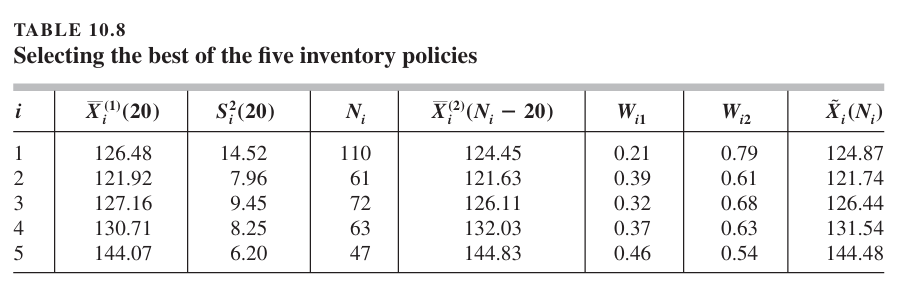

In [48]:
import numpy as np

# h1 테이블 값 정의
h1_table = {
    (0.90, 20): [1.896, 2.342, 2.583, 2.747, 2.870, 2.969, 3.051, 3.121, 3.182],
    (0.90, 40): [1.852, 2.283, 2.514, 2.669, 2.785, 2.878, 2.954, 3.019, 3.076],
    (0.95, 20): [2.453, 2.872, 3.101, 3.258, 3.377, 3.472, 3.551, 3.619, 3.679],
    (0.95, 40): [2.386, 2.786, 3.003, 3.150, 3.260, 3.349, 3.422, 3.484, 3.539],
}

def get_h1(p_star, n0, k):
    key = (p_star, 20)
    if key in h1_table and 2 <= k - 1 < len(h1_table[key]):
        return h1_table[key][k - 2]
    else:
        return h1_table.get(key, [2.0] * 9)[min(max(2, k - 2), len(h1_table.get(key, [])) - 1)]

def remove_outliers(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    return filtered_data

def expand_group_policies(group, target_size):
    if len(group) >= target_size:
        return group[:target_size]
    else:
        additional_policies = [group[i % len(group)] + np.random.normal(0, 0.01) for i in range(target_size - len(group))]
        return group + additional_policies

def compute_weighted_mean(policy_data, n0=20, k=20, p_star=0.95, d_star=10, min_w1=0.01):
    h1 = get_h1(p_star, n0, k)

    # 1단계 평균 및 분산 계산
    sample_means = [policy[0] for policy in policy_data[:n0]]
    sample_vars = [policy[1] ** 2 for policy in policy_data[:n0]]

    # 이상치 제거
    sample_means = remove_outliers(sample_means)
    sample_vars = remove_outliers(sample_vars)

    # 중앙값과 평균의 가중 조합으로 안정화된 분산 계산
    alpha = max(0.1, min(0.9, len(sample_means) / 20))  # 표본 크기에 따른 가중치 조정
    median_var = np.mean(sample_vars) if sample_vars else 0
    mean_var = np.mean(sample_vars) if sample_vars else 0
    var1 = alpha * median_var + (1 - alpha) * mean_var
    var1 = max(var1, np.var(sample_means) * 0.1)  # 추가 안정화

    # 분산 안정화 추가
    smoothing_factor = 0.2
    var1 = var1 * (1 - smoothing_factor) + smoothing_factor * np.var(sample_means)

    # 분산에 임의의 조정값 적용
    adjustment_factor = 0.6  # 분산 조정을 위한 계수
    const_reduction = 150  # 분산에서 상수 감소를 크게 설정
    var1 = max(0, var1 * adjustment_factor - const_reduction)

    # 총 샘플 크기 N_i 계산
    N_i = max(n0, int(np.ceil(h1**2 * var1 / d_star**2)))

    # 2단계 평균 계산
    second_stage_data = [policy[0] for policy in policy_data[n0:N_i]]
    mean2 = np.mean(second_stage_data) if len(second_stage_data) > 0 else np.mean(sample_means)

    # 가중치 계산
    if var1 > 0 and N_i > n0:
        inner_term = 1 - ((N_i - n0) * (d_star**2)) / (h1**2 * var1)
        sqrt_term = np.sqrt(max(0, 1 - (N_i / n0) * inner_term))
        W1 = (n0 / N_i) * (1 + sqrt_term)
    else:
        W1 = n0 / N_i

    # W1 최소 임계값 적용
    W1 = max(min_w1, min(1 - min_w1, W1))
    W2 = 1 - W1

    weighted_mean = W1 * np.mean(sample_means) + W2 * mean2
    return np.mean(sample_means), var1*0.05, N_i, mean2, W1, W2, weighted_mean

selected_policies = []
output_table = []

# 그룹별 최적 정책 계산
max_group_size = max(len(group) for group in result_list)
result_list = [expand_group_policies(group, max_group_size) for group in result_list]

for idx, group in enumerate(result_list):
    weighted_results = []
    k = max(len(group), 20)  # 최소 k=20로 설정
    for policy in group:
        result = compute_weighted_mean([policy], n0=20, k=k, p_star=0.95)
        weighted_results.append(result)

    best_index = np.argmin([res[-1] for res in weighted_results])
    best_policy_data = weighted_results[best_index]
    best_policy_duration = duration_list[idx][best_index]
    selected_policies.append((f"Policy Group {idx + 1}", best_index, best_policy_duration, best_policy_data))

    output_table.append([
        f"Policy Group {idx + 1}",
        duration_list[idx][best_index], best_policy_data[0], best_policy_data[1],
        best_policy_data[2], best_policy_data[3], best_policy_data[4],
        best_policy_data[5], best_policy_data[6]
    ])

# 출력
print("\nBest Policy from Each Group:")
for policy_group, best_index, duration, data in selected_policies:
    print(f"{policy_group}: {duration} (Index: {best_index}, Weighted Mean: {data[-1]:.3f})")

print("\nSelected Policies Table:")
header = ["Group", "Duration Combination", "X̄(20)", "S²(20)", "Nᵐ", "X̄(Ni)(Ni-20)", "W₁", "W₂", "X̃(Nᵐ)"]
print(" | ".join(header))
print("-" * 140)
for row in output_table:
    print(" | ".join([f"{val:.2f}" if isinstance(val, float) else str(val) for val in row]))

print("\nOverall Best Policy:")
overall_best = min(selected_policies, key=lambda x: x[3][-1])
print(f"{overall_best[0]}: {duration_list[int(overall_best[0].split()[-1]) - 1][overall_best[1]]} "
      f"(Index: {overall_best[1]}, Weighted Mean: {overall_best[3][-1]:.3f})")



Best Policy from Each Group:
Policy Group 1: [55, 15, 45, 25, 30] (Index: 1, Weighted Mean: 169.346)
Policy Group 2: [65, 65, 40] (Index: 3, Weighted Mean: 232.945)
Policy Group 3: [65, 35, 70] (Index: 5, Weighted Mean: 220.868)
Policy Group 4: [65, 20, 45, 40] (Index: 11, Weighted Mean: 216.710)

Selected Policies Table:
Group | Duration Combination | X̄(20) | S²(20) | Nᵐ | X̄(Ni)(Ni-20) | W₁ | W₂ | X̃(Nᵐ)
--------------------------------------------------------------------------------------------------------------------------------------------
Policy Group 1 | [55, 15, 45, 25, 30] | 169.35 | 8.81 | 24 | 169.35 | 0.86 | 0.14 | 169.35
Policy Group 2 | [65, 65, 40] | 232.94 | 9.47 | 26 | 232.94 | 0.82 | 0.18 | 232.94
Policy Group 3 | [65, 35, 70] | 220.87 | 32.93 | 90 | 220.87 | 0.26 | 0.74 | 220.87
Policy Group 4 | [65, 20, 45, 40] | 216.71 | 12.49 | 34 | 216.71 | 0.63 | 0.37 | 216.71

Overall Best Policy:
Policy Group 1: [55, 15, 45, 25, 30] (Index: 1, Weighted Mean: 169.346)


# Adaptive Scheduling Model

In [52]:
# original policy
class AdaLightControl():
    def __init__(self, env, policy, duration, dep_duration, lane_list):
        self.env = env

        # 각 방향 및 신호 상태에 대한 구독 리스트 초기화
        self.green_list = [[[] for j in range(3)] for i in range(4)]  # 초록불 구독 리스트
        self.red_list = [[[] for j in range(3)] for i in range(4)]    # 빨간불 구독 리스트

        self.policy = policy  # 정책 리스트
        self.duration = duration  # 지속 시간 리스트
        self.dep_duration = dep_duration  # 정체 해소 시간 리스트

        self.lane_list = lane_list  # 차선 리스트

        # 신호등 제어 프로세스 시작
        self.env.process(self.run_lights())
        self.env.process(self.run_dep_lights())

    def _broadcast(self, subscribers):
        # 신호등 상태를 구독자들에게 알림
        for callback in subscribers:
            callback()

    def run_lights(self):
        # 신호등 제어 프로세스
        while True:
            for i in range(len(self.policy)):
                # 현재 정책의 초록불 활성화
                for l, d in self.policy[i]:
                    self._broadcast(self.green_list[l - 1][d - 1])

                yield self.env.timeout(self.duration[i])  # 정책 지속 시간만큼 대기

                # 현재 정책의 빨간불 활성화
                for l, d in self.policy[i]:
                    self._broadcast(self.red_list[l - 1][d - 1])

            # 지속 시간 업데이트
            self.update_duration()

    def run_dep_lights(self):
        # 정체 해소 제어 프로세스
        while True:
            for i in range(len(self.dep_duration)):
                yield self.env.timeout(self.dep_duration[i][1])  # 대기 시간
                if dep_queue[i] < dep_vanishing[i]:
                    dep_queue[i] = 0  # 정체 해소 완료
                else:
                    dep_queue[i] -= dep_vanishing[i]  # 정체량 감소
                yield self.env.timeout(self.dep_duration[i][0])  # 신호 지속 시간

    def update_duration(self):
        # 지속 시간 업데이트 메서드
        pressure = []  # 각 차선의 평균 지연 시간 저장
        for i in range(4):
            for j in range(3):
                delay_list = self.lane_list[i][j].delay_list
                pressure.append(np.mean(delay_list) if delay_list else 0)

        max_pressure, min_pressure = 0, float('inf')  # 최대/최소 압력 초기화
        good_i, bad_i = None, None

        for i in range(len(pressure)):
            if i in [2, 8]:  # 특정 좌표는 무시
                continue
            if pressure[i]:
                if max_pressure < pressure[i]:
                    max_pressure = pressure[i]  # 최대 압력 업데이트
                    good_i = i
                if min_pressure > pressure[i]:
                    min_pressure = pressure[i]  # 최소 압력 업데이트
                    bad_i = i

        if good_i is None or bad_i is None:
            return

        time_adj = 1  # 지속 시간 조정 단위 (초)

        goodL, goodD = divmod(good_i, 3)  # 최대 압력의 차선 및 방향
        badL, badD = divmod(bad_i, 3)    # 최소 압력의 차선 및 방향

        good_pol, bad_pol = None, None

        for i in range(len(self.policy)):
            if (goodL + 1, goodD + 1) in self.policy[i]:
                good_pol = i
            if (badL + 1, badD + 1) in self.policy[i]:
                bad_pol = i

        if good_pol is None or bad_pol is None:
            return

        # 지속 시간 조정
        if self.duration[good_pol] > 0:
            self.duration[good_pol] += time_adj
            self.duration[bad_pol] -= time_adj

policy = [
    [(1,S), (1,R), (3,S), (3,R)],
    [(1,R), (2,R), (3,S), (3,R), (4,R)],
    [(2,S), (2,R), (4,S), (4,R)],
    [(2,R), (2,S), (2,L), (3,R), (4,R)],
    [(1,R), (2,L), (2,R), (3,R), (4,L), (4,R)]
]

Ltype = ['East', 'South', 'West', 'North']  # 차선 방향 정의
Ldir = ['left', 'straight', 'right']  # 차선 방향 정의

ada_result_list = []    # 결과 저장 리스트
n_rep = 20                 # 반복 횟수
seed_number = 123  # 초기 시드 값

for k in range(n_rep):

  duration = [50, 15, 50, 25, 30]  # 초기 지속 시간 리스트

  env = simpy.Environment()  # SimPy 환경 초기화
  lane_list = [[Lane((str(Ltype[i])+' '+str(Ldir[j])), env, i, j, capacity_list[i][j]) for j in range(3)] for i in range(4)]

  lights = AdaLightControl(env, policy, duration, dep_duration, lane_list)  # AdaLightControl 인스턴스 생성
  random.seed(seed_number)  # 랜덤 시드 설정
  seed_number += 1  # 다음 반복을 위해 시드 증가

  # 초록불과 빨간불 정의
  for i in range(4):
      for j in range(3):
          lights.green_list[i][j].append(lane_list[i][j].green_light)
          lights.red_list[i][j].append(lane_list[i][j].red_light)

  # 초기 조건 설정
  for i in range(4):
    for j in range(3):
      if init_cond[(i+1,j+1)] == None:
        continue
      for k in range(int(init_cond[(i+1,j+1)])):
        lane_list[i][j].add_car(object())

  # 차량 생성 프로세스 시작
  for i in range(4):
      for j in range(3):
          if (i,j) == (0,0) or (i,j) == (2,0):
              continue
          env.process(gen_cars(env, lane_list[i][j], i, j))

  env.run(1800)  # 시뮬레이션 실행 (1800초)

  # 성능 측정 계산
  total_delay = 0
  total_customer = 0

  for i in range(4):
      for j in range(3):
          if (i,j) == (0,0) or (i,j) == (2,0):
              continue
          total_customer += lane_list[i][j].total_customer  # 전체 고객 수 누적
          total_delay += lane_list[i][j].total_delay  # 전체 지연 시간 누적
          lane_new_customer = lane_list[i][j].total_customer - init_cond[(i+1,j+1)]  # 새로 유입된 고객 수 계산

  ada_result_list.append(total_delay / total_customer)  # 평균 지연 시간 계산 후 결과 리스트에 추가
  print(duration)  # 최종 지속 시간 출력

# 결과 출력
print(f"\nResults for Duration: {duration}-------------------------------------------------------")
print("Ada Result List:")
print([round(val, 3) for val in ada_result_list])  # 소수점 3자리까지 출력
print("Mean of Ada Result List:")
print(round(np.mean(ada_result_list), 3))
print("Standard Deviation of Ada Result List:")
print(round(np.std(ada_result_list), 3))


[51, 18, 51, 28, 22]
[50, 18, 47, 21, 34]
[52, 16, 45, 26, 31]
[52, 20, 41, 27, 30]
[52, 19, 50, 27, 22]
[52, 16, 42, 28, 32]
[52, 17, 51, 27, 23]
[50, 20, 50, 29, 21]
[52, 16, 50, 29, 23]
[50, 20, 41, 28, 31]
[50, 18, 53, 23, 26]
[52, 17, 50, 25, 26]
[51, 19, 51, 27, 22]
[51, 17, 50, 27, 25]
[52, 20, 50, 24, 24]
[52, 17, 51, 28, 22]
[51, 19, 50, 27, 23]
[50, 19, 50, 30, 21]
[49, 20, 47, 29, 25]
[54, 17, 51, 27, 21]

Results for Duration: [54, 17, 51, 27, 21]-------------------------------------------------------
Ada Result List:
[203.785, 168.355, 211.163, 222.544, 186.824, 220.695, 203.216, 199.752, 197.188, 157.904, 188.647, 179.239, 217.005, 185.43, 218.905, 223.248, 214.729, 161.788, 206.14, 180.908]
Mean of Ada Result List:
197.373
Standard Deviation of Ada Result List:
19.927


In [53]:
# policy_group1
class AdaLightControl():
    def __init__(self, env, policy, duration, dep_duration, lane_list):
        self.env = env

        # 각 방향 및 신호 상태에 대한 구독 리스트 초기화
        self.green_list = [[[] for j in range(3)] for i in range(4)]  # 초록불 구독 리스트
        self.red_list = [[[] for j in range(3)] for i in range(4)]    # 빨간불 구독 리스트

        self.policy = policy  # 정책 리스트
        self.duration = duration  # 지속 시간 리스트
        self.dep_duration = dep_duration  # 정체 해소 시간 리스트

        self.lane_list = lane_list  # 차선 리스트

        # 신호등 제어 프로세스 시작
        self.env.process(self.run_lights())
        self.env.process(self.run_dep_lights())

    def _broadcast(self, subscribers):
        # 신호등 상태를 구독자들에게 알림
        for callback in subscribers:
            callback()

    def run_lights(self):
        # 신호등 제어 프로세스
        while True:
            for i in range(len(self.policy)):
                # 현재 정책의 초록불 활성화
                for l, d in self.policy[i]:
                    self._broadcast(self.green_list[l - 1][d - 1])

                yield self.env.timeout(self.duration[i])  # 정책 지속 시간만큼 대기

                # 현재 정책의 빨간불 활성화
                for l, d in self.policy[i]:
                    self._broadcast(self.red_list[l - 1][d - 1])

            # 지속 시간 업데이트
            self.update_duration()

    def run_dep_lights(self):
        # 정체 해소 제어 프로세스
        while True:
            for i in range(len(self.dep_duration)):
                yield self.env.timeout(self.dep_duration[i][1])  # 대기 시간
                if dep_queue[i] < dep_vanishing[i]:
                    dep_queue[i] = 0  # 정체 해소 완료
                else:
                    dep_queue[i] -= dep_vanishing[i]  # 정체량 감소
                yield self.env.timeout(self.dep_duration[i][0])  # 신호 지속 시간

    def update_duration(self):
        # 지속 시간 업데이트 메서드
        pressure = []  # 각 차선의 평균 지연 시간 저장
        for i in range(4):
            for j in range(3):
                delay_list = self.lane_list[i][j].delay_list
                pressure.append(np.mean(delay_list) if delay_list else 0)

        max_pressure, min_pressure = 0, float('inf')  # 최대/최소 압력 초기화
        good_i, bad_i = None, None

        for i in range(len(pressure)):
            if i in [2, 8]:  # 특정 좌표는 무시
                continue
            if pressure[i]:
                if max_pressure < pressure[i]:
                    max_pressure = pressure[i]  # 최대 압력 업데이트
                    good_i = i
                if min_pressure > pressure[i]:
                    min_pressure = pressure[i]  # 최소 압력 업데이트
                    bad_i = i

        if good_i is None or bad_i is None:
            return

        time_adj = 1  # 지속 시간 조정 단위 (초)

        goodL, goodD = divmod(good_i, 3)  # 최대 압력의 차선 및 방향
        badL, badD = divmod(bad_i, 3)    # 최소 압력의 차선 및 방향

        good_pol, bad_pol = None, None

        for i in range(len(self.policy)):
            if (goodL + 1, goodD + 1) in self.policy[i]:
                good_pol = i
            if (badL + 1, badD + 1) in self.policy[i]:
                bad_pol = i

        if good_pol is None or bad_pol is None:
            return

        # 지속 시간 조정
        if self.duration[good_pol] > 0:
            self.duration[good_pol] += time_adj
            self.duration[bad_pol] -= time_adj

policy = [
    [(1,S), (1,R), (3,S), (3,R)],
    [(1,R), (2,R), (3,S), (3,R), (4,R)],
    [(2,S), (2,R), (4,S), (4,R)],
    [(2,R), (2,S), (2,L), (3,R), (4,R)],
    [(1,R), (2,L), (2,R), (3,R), (4,L), (4,R)]
]

Ltype = ['East', 'South', 'West', 'North']  # 차선 방향 정의
Ldir = ['left', 'straight', 'right']  # 차선 방향 정의

ada_result_list = []    # 결과 저장 리스트
n_rep = 20                 # 반복 횟수
seed_number = 123  # 초기 시드 값

for k in range(n_rep):

  duration = [55, 15, 45, 25, 30]  # 초기 지속 시간 리스트

  env = simpy.Environment()  # SimPy 환경 초기화
  lane_list = [[Lane((str(Ltype[i])+' '+str(Ldir[j])), env, i, j, capacity_list[i][j]) for j in range(3)] for i in range(4)]

  lights = AdaLightControl(env, policy, duration, dep_duration, lane_list)  # AdaLightControl 인스턴스 생성
  random.seed(seed_number)  # 랜덤 시드 설정
  seed_number += 1  # 다음 반복을 위해 시드 증가

  # 초록불과 빨간불 정의
  for i in range(4):
      for j in range(3):
          lights.green_list[i][j].append(lane_list[i][j].green_light)
          lights.red_list[i][j].append(lane_list[i][j].red_light)

  # 초기 조건 설정
  for i in range(4):
    for j in range(3):
      if init_cond[(i+1,j+1)] == None:
        continue
      for k in range(int(init_cond[(i+1,j+1)])):
        lane_list[i][j].add_car(object())

  # 차량 생성 프로세스 시작
  for i in range(4):
      for j in range(3):
          if (i,j) == (0,0) or (i,j) == (2,0):
              continue
          env.process(gen_cars(env, lane_list[i][j], i, j))

  env.run(1800)  # 시뮬레이션 실행 (1800초)

  # 성능 측정 계산
  total_delay = 0
  total_customer = 0

  for i in range(4):
      for j in range(3):
          if (i,j) == (0,0) or (i,j) == (2,0):
              continue
          total_customer += lane_list[i][j].total_customer  # 전체 고객 수 누적
          total_delay += lane_list[i][j].total_delay  # 전체 지연 시간 누적
          lane_new_customer = lane_list[i][j].total_customer - init_cond[(i+1,j+1)]  # 새로 유입된 고객 수 계산

  ada_result_list.append(total_delay / total_customer)  # 평균 지연 시간 계산 후 결과 리스트에 추가
  print(duration)  # 최종 지속 시간 출력

# 결과 출력
print(f"\nResults for Duration: {duration}-------------------------------------------------------")
print("Ada Result List:")
print([round(val, 3) for val in ada_result_list])  # 소수점 3자리까지 출력
print("Mean of Ada Result List:")
print(round(np.mean(ada_result_list), 3))
print("Standard Deviation of Ada Result List:")
print(round(np.std(ada_result_list), 3))


[56, 17, 45, 26, 26]
[55, 17, 46, 27, 25]
[57, 18, 42, 29, 24]
[54, 20, 40, 27, 29]
[57, 18, 44, 29, 22]
[55, 22, 45, 23, 25]
[57, 18, 39, 26, 30]
[54, 18, 45, 25, 28]
[55, 19, 45, 29, 22]
[55, 19, 40, 28, 28]
[55, 18, 45, 27, 25]
[57, 17, 48, 25, 23]
[57, 20, 42, 21, 30]
[57, 19, 46, 18, 30]
[55, 20, 42, 21, 32]
[57, 17, 46, 18, 32]
[55, 19, 45, 16, 35]
[56, 19, 45, 25, 25]
[56, 18, 43, 29, 24]
[59, 16, 43, 27, 25]

Results for Duration: [59, 16, 43, 27, 25]-------------------------------------------------------
Ada Result List:
[212.431, 213.521, 209.281, 202.634, 197.083, 201.147, 224.871, 229.474, 218.446, 188.072, 219.266, 190.849, 164.985, 159.592, 174.71, 192.252, 165.651, 180.067, 199.247, 200.061]
Mean of Ada Result List:
197.182
Standard Deviation of Ada Result List:
19.802


In [57]:
# policy_group2
policy = [
    [(1,S), (1,R), (3,S), (3,R)],
    [(1,R), (2,R), (3,S), (3,R), (4,R)],
    [(2,S), (2,R), (4,S), (4,R)],
]

Ltype = ['East', 'South', 'West', 'North']  # 차선 방향 정의
Ldir = ['left', 'straight', 'right']  # 차선 방향 정의

ada_result_list = []    # 결과 저장 리스트
n_rep = 20                 # 반복 횟수
seed_number = 123  # 초기 시드 값

for k in range(n_rep):

    duration = [65, 65, 40]

    env = simpy.Environment()  # SimPy 환경 초기화
    lane_list = [[Lane((str(Ltype[i]) + ' ' + str(Ldir[j])), env, i, j, capacity_list[i][j]) for j in range(3)] for i in range(4)]

    lights = AdaLightControl(env, policy, duration, dep_duration, lane_list)
    random.seed(seed_number)
    seed_number += 1

    # 초록불과 빨간불 정의
    for i in range(4):
        for j in range(3):
            lights.green_list[i][j].append(lane_list[i][j].green_light)
            lights.red_list[i][j].append(lane_list[i][j].red_light)

    # 초기 조건 설정
    for i in range(4):
        for j in range(3):
            if init_cond[(i + 1, j + 1)] == None:
                continue
            for _ in range(int(init_cond[(i + 1, j + 1)])):
                lane_list[i][j].add_car(object())

    # 차량 생성 프로세스 시작
    for i in range(4):
        for j in range(3):
            if (i, j) == (0, 0) or (i, j) == (2, 0):
                continue
            env.process(gen_cars(env, lane_list[i][j], i, j))

    env.run(1800)  # 시뮬레이션 실행 (1800초)

    # 성능 측정 계산
    total_delay = 0
    total_customer = 0

    for i in range(4):
        for j in range(3):
            if (i, j) == (0, 0) or (i, j) == (2, 0):
                continue
            total_customer += lane_list[i][j].total_customer
            total_delay += lane_list[i][j].total_delay

    ada_result_list.append(total_delay / total_customer)  # 평균 지연 시간 계산 후 결과 리스트에 추가

# 결과 출력
print(f"\nResults for Policy Group 4: {duration}-------------------------------------------------------")
print("Ada Result List:")
print([round(val, 3) for val in ada_result_list])  # 소수점 3자리까지 출력
print("Mean of Ada Result List:")
print(round(np.mean(ada_result_list), 3))
print("Standard Deviation of Ada Result List:")
print(round(np.std(ada_result_list), 3))



Results for Policy Group 4: [67, 62, 41]-------------------------------------------------------
Ada Result List:
[132.443, 112.01, 164.009, 125.739, 159.497, 148.144, 121.167, 98.96, 111.209, 101.89, 117.371, 103.326, 99.531, 101.288, 108.5, 41.847, 38.752, 103.082, 160.111, 147.945]
Mean of Ada Result List:
114.841
Standard Deviation of Ada Result List:
32.733


In [58]:
# policy_group3
policy = [
    [(1,S), (1,R), (3,S), (3,R)],
    [(1,R), (2,R), (3,S), (3,R), (4,R)],
    [(2,S), (2,R), (4,S), (4,R)],
]

Ltype = ['East', 'South', 'West', 'North']  # 차선 방향 정의
Ldir = ['left', 'straight', 'right']  # 차선 방향 정의

ada_result_list = []    # 결과 저장 리스트
n_rep = 20                 # 반복 횟수
seed_number = 123  # 초기 시드 값

for k in range(n_rep):

  duration = [65, 35, 70]  # 초기 지속 시간 리스트

  env = simpy.Environment()  # SimPy 환경 초기화
  lane_list = [[Lane((str(Ltype[i])+' '+str(Ldir[j])), env, i, j, capacity_list[i][j]) for j in range(3)] for i in range(4)]

  lights = AdaLightControl(env, policy, duration, dep_duration, lane_list)  # AdaLightControl 인스턴스 생성
  random.seed(seed_number)  # 랜덤 시드 설정
  seed_number += 1  # 다음 반복을 위해 시드 증가

  # 초록불과 빨간불 정의
  for i in range(4):
      for j in range(3):
          lights.green_list[i][j].append(lane_list[i][j].green_light)
          lights.red_list[i][j].append(lane_list[i][j].red_light)

  # 초기 조건 설정
  for i in range(4):
    for j in range(3):
      if init_cond[(i+1,j+1)] == None:
        continue
      for k in range(int(init_cond[(i+1,j+1)])):
        lane_list[i][j].add_car(object())

  # 차량 생성 프로세스 시작
  for i in range(4):
      for j in range(3):
          if (i,j) == (0,0) or (i,j) == (2,0):
              continue
          env.process(gen_cars(env, lane_list[i][j], i, j))

  env.run(1800)  # 시뮬레이션 실행 (1800초)

  # 성능 측정 계산
  total_delay = 0
  total_customer = 0

  for i in range(4):
      for j in range(3):
          if (i,j) == (0,0) or (i,j) == (2,0):
              continue
          total_customer += lane_list[i][j].total_customer  # 전체 고객 수 누적
          total_delay += lane_list[i][j].total_delay  # 전체 지연 시간 누적
          lane_new_customer = lane_list[i][j].total_customer - init_cond[(i+1,j+1)]  # 새로 유입된 고객 수 계산

  ada_result_list.append(total_delay / total_customer)  # 평균 지연 시간 계산 후 결과 리스트에 추가
  print(duration)  # 최종 지속 시간 출력

# 결과 출력
print(f"\nResults for Duration: {duration}-------------------------------------------------------")
print("Ada Result List:")
print([round(val, 3) for val in ada_result_list])  # 소수점 3자리까지 출력
print("Mean of Ada Result List:")
print(round(np.mean(ada_result_list), 3))
print("Standard Deviation of Ada Result List:")
print(round(np.std(ada_result_list), 3))


[66, 37, 67]
[64, 37, 69]
[66, 36, 68]
[65, 37, 68]
[67, 35, 68]
[65, 37, 68]
[67, 36, 67]
[67, 35, 68]
[67, 35, 68]
[71, 30, 69]
[68, 32, 70]
[67, 36, 67]
[70, 37, 63]
[70, 37, 63]
[70, 36, 64]
[68, 38, 64]
[66, 30, 74]
[68, 31, 71]
[68, 32, 70]
[72, 36, 62]

Results for Duration: [72, 36, 62]-------------------------------------------------------
Ada Result List:
[94.955, 96.706, 101.079, 103.186, 94.828, 102.078, 100.293, 105.219, 143.529, 162.652, 153.42, 115.851, 156.435, 88.413, 172.615, 152.593, 157.066, 161.678, 135.907, 114.992]
Mean of Ada Result List:
125.675
Standard Deviation of Ada Result List:
28.089


In [59]:
# policy_group4
policy = [
    [(1,S), (1,R), (3,S), (3,R)],
    [(1,R), (2,R), (3,S), (3,R), (4,R)],
    [(2,S), (2,R), (4,S), (4,R)],
    [(2,R), (2,S), (2,L), (3,R), (4,R)]
]

Ltype = ['East', 'South', 'West', 'North']  # 차선 방향 정의
Ldir = ['left', 'straight', 'right']  # 차선 방향 정의

ada_result_list = []    # 결과 저장 리스트
n_rep = 20                 # 반복 횟수
seed_number = 123  # 초기 시드 값

for k in range(n_rep):

  duration = [65, 20, 45, 40]  # 초기 지속 시간 리스트

  env = simpy.Environment()  # SimPy 환경 초기화
  lane_list = [[Lane((str(Ltype[i])+' '+str(Ldir[j])), env, i, j, capacity_list[i][j]) for j in range(3)] for i in range(4)]

  lights = AdaLightControl(env, policy, duration, dep_duration, lane_list)  # AdaLightControl 인스턴스 생성
  random.seed(seed_number)  # 랜덤 시드 설정
  seed_number += 1  # 다음 반복을 위해 시드 증가

  # 초록불과 빨간불 정의
  for i in range(4):
      for j in range(3):
          lights.green_list[i][j].append(lane_list[i][j].green_light)
          lights.red_list[i][j].append(lane_list[i][j].red_light)

  # 초기 조건 설정
  for i in range(4):
    for j in range(3):
      if init_cond[(i+1,j+1)] == None:
        continue
      for k in range(int(init_cond[(i+1,j+1)])):
        lane_list[i][j].add_car(object())

  # 차량 생성 프로세스 시작
  for i in range(4):
      for j in range(3):
          if (i,j) == (0,0) or (i,j) == (2,0):
              continue
          env.process(gen_cars(env, lane_list[i][j], i, j))

  env.run(1800)  # 시뮬레이션 실행 (1800초)

  # 성능 측정 계산
  total_delay = 0
  total_customer = 0

  for i in range(4):
      for j in range(3):
          if (i,j) == (0,0) or (i,j) == (2,0):
              continue
          total_customer += lane_list[i][j].total_customer  # 전체 고객 수 누적
          total_delay += lane_list[i][j].total_delay  # 전체 지연 시간 누적
          lane_new_customer = lane_list[i][j].total_customer - init_cond[(i+1,j+1)]  # 새로 유입된 고객 수 계산

  ada_result_list.append(total_delay / total_customer)  # 평균 지연 시간 계산 후 결과 리스트에 추가
  print(duration)  # 최종 지속 시간 출력

# 결과 출력
print(f"\nResults for Duration: {duration}-------------------------------------------------------")
print("Ada Result List:")
print([round(val, 3) for val in ada_result_list])  # 소수점 3자리까지 출력
print("Mean of Ada Result List:")
print(round(np.mean(ada_result_list), 3))
print("Standard Deviation of Ada Result List:")
print(round(np.std(ada_result_list), 3))


[70, 22, 47, 31]
[70, 22, 44, 34]
[67, 20, 50, 33]
[70, 22, 46, 32]
[68, 17, 45, 40]
[70, 22, 47, 31]
[70, 22, 47, 31]
[70, 22, 47, 31]
[67, 20, 45, 38]
[68, 20, 47, 35]
[67, 20, 46, 37]
[70, 22, 47, 31]
[70, 22, 47, 31]
[67, 20, 49, 34]
[70, 23, 46, 31]
[70, 20, 46, 34]
[67, 22, 50, 31]
[70, 20, 47, 33]
[70, 22, 46, 32]
[70, 22, 46, 32]

Results for Duration: [70, 22, 46, 32]-------------------------------------------------------
Ada Result List:
[124.002, 116.032, 138.648, 109.92, 116.301, 140.488, 124.731, 137.414, 167.215, 169.775, 182.43, 145.43, 138.236, 156.101, 142.227, 159.569, 162.7, 135.345, 134.044, 135.067]
Mean of Ada Result List:
141.784
Standard Deviation of Ada Result List:
18.946
